# Twitter Sentiment Analysis

### Problem Statement
The task is to build a model that will determine the tone (neutral, positive, negative) of the text. To do this, you will need to train the model on the existing data (train.csv). The resulting model will have to determine the class (neutral, positive, negative) of new texts (test data that were not used to build the model) with maximum accuracy.

### Performance metric
Source: https://www.kaggle.com/competitions/twitter-sentiment-analysis2/overview/evaluation

Metric:
    F1-score

Loading the required libraries

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from tabulate import tabulate
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,Activation
from tensorflow.keras.models import Model
import random as rn
from sklearn.metrics import f1_score, roc_auc_score
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import os
import tensorflow_addons as tfa
from tensorflow.keras import backend as K
import tensorflow_hub as hub
import tensorflow_text as text

#### Data source: https://www.kaggle.com/competitions/twitter-sentiment-analysis2/data 

#### Data description:

File descriptions
    <ul>train.csv - the training set</ul>
    <ul>test.csv - the test set</ul>

Data fields:
    <ul>ItemID - id of tweet</ul>
    <ul>SentimentText - text of the tweet</ul>
    <ul>Sentiment - sentiment</ul>
        <ul>0 - negative</ul>
        <ul>1 - positive</ul>

### Loading the data

In [3]:
train = pd.read_csv(r"D:\Twitter Sentiment Analysis\Dataset\train.csv", encoding='latin-1')
train.head(4)

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...


In [4]:
print(train.shape)

(99989, 3)


### Data Visualization

In [5]:
print("Null data in the train dataset:\n", train.isnull().any())

Null data in the train dataset:
 ItemID           False
Sentiment        False
SentimentText    False
dtype: bool


<AxesSubplot:>

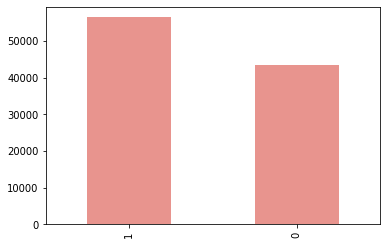

In [6]:
train['Sentiment'].value_counts().plot.bar(color='#e8948e', figsize=(6,4))

Since, the dataset is slightly imbalanced and is large enough resulting in the increase of training time for deep learning models we will use random sampling to makee both class labels equal 

<AxesSubplot:ylabel='Frequency'>

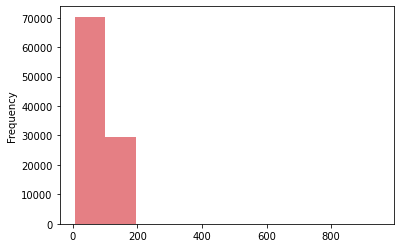

In [18]:
train['SentimentText'].str.len().plot.hist(color='#E57F84', figsize=(6,4))

In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anike\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
stop_words.remove('not')
stop_words.remove('no')
print("Stop Words :\n", stop_words)

Stop Words :
 {'at', 'will', 'am', 'has', 'aren', 'if', 'as', 'off', "shouldn't", 'yourself', 'or', 'than', 'me', 'your', 'out', 'mightn', 'did', 'had', 'these', 'and', 'to', 'down', 'd', "mightn't", 'is', 'do', 'after', 'again', 'on', 'above', 'more', 'what', "don't", 'his', 'where', 'wasn', "shan't", 's', 'for', 're', 'yourselves', "won't", "haven't", 'between', 'from', "couldn't", 'ma', 'our', 'through', "should've", 'until', 'her', "weren't", 'she', 'mustn', "wasn't", 've', 'doesn', 'being', 'very', 'hasn', 'once', 'why', 'herself', 'just', 'it', 'itself', 'm', 'he', 'by', 'didn', 'shan', 'don', "that'll", "you'd", 'does', "didn't", 'isn', 'before', 'weren', 'during', 'been', 'other', "aren't", 'how', 'any', 'each', 'was', 'too', 'i', "it's", "hasn't", 'now', 'they', 'himself', 'an', 'themselves', "you've", 'then', 'some', 'y', 'here', 'theirs', 'myself', 'those', 'o', "isn't", 'against', "wouldn't", 'own', 'wouldn', 'yours', 'over', 'under', 'hers', 'most', "you're", 'whom', 'abou

In [21]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(train['SentimentText'])

sum_words = words.sum(axis=0)

word_freq = [(word, sum_words[0,i]) for word,i in cv.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x:x[1], reverse=True)

Text(0.5, 1.0, 'Word Cloud for Setiment Text')

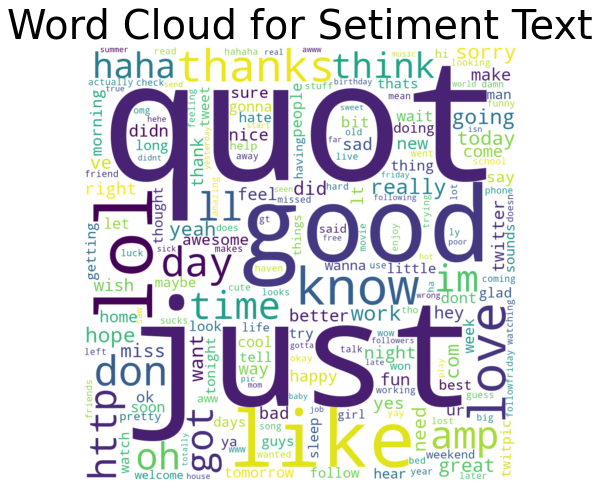

In [22]:
wc = WordCloud(background_color='White', width = 1000, height = 1000).generate_from_frequencies(dict(word_freq))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(wc, interpolation = 'bilinear')
plt.title("Word Cloud for Setiment Text", fontsize=40)

Text(0.5, 1.0, 'Word Cloud for positive words')

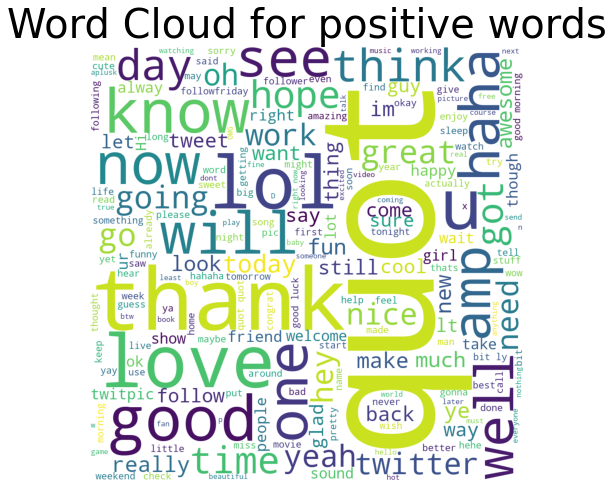

In [23]:
positive_words = ' '.join([word for word in train['SentimentText'][train['Sentiment']==1]])
positive_wc = WordCloud(background_color='White', width = 1000, height = 1000).generate(positive_words)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(positive_wc)
plt.title("Word Cloud for positive words", fontsize=40)

Text(0.5, 1.0, 'Word Cloud for negative words')

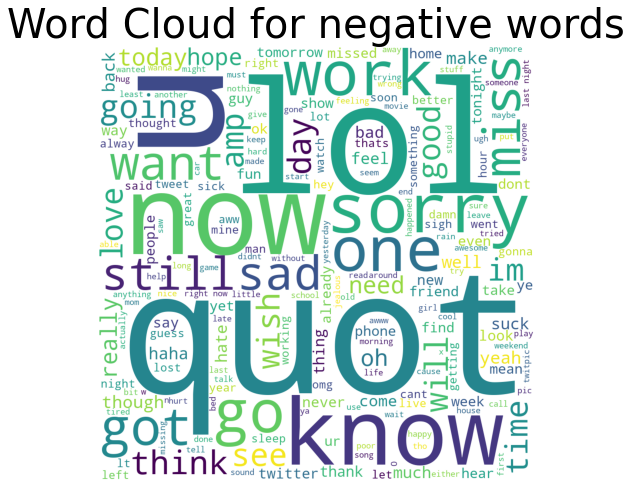

In [24]:
negative_words = ' '.join([word for word in train['SentimentText'][train['Sentiment']==0]])
negative_wc = WordCloud(background_color='White', width = 1000, height = 1000).generate(negative_words)
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(negative_wc)
plt.title("Word Cloud for negative words", fontsize=40)

### Data cleaning and preprocessing

In [25]:
snow_stemmer = SnowballStemmer(language='english')
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anike\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [27]:
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [28]:
def text_preprocessing(text):
    text = re.sub('@[^\s]+', '', text) 
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) 
    text = re.sub('[^a-zA-Z\n]', ' ', text)
    text = re.sub('\s+',' ', text)
    text = re.sub("\n", " ", text)
    text = re.sub("\t", " ", text)  
    text = re.sub(",", ", ", text)
    #text = ' '.join(words for words in text.split(" ") if len(words)>2)
    text = ' '.join(words for words in text.split(" "))
    text = decontracted(text)
    text = re.sub(r'(.)\1{3,}',r'\1', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip().lower()

In [29]:
def stop_and_stem(text):
    text = ' '.join(words.lower() for words in text.split(" ") if words not in stop_words)
    word_list = nltk.word_tokenize(text)
    text = ' '.join(snow_stemmer.stem(word) for word in word_list)
    text = ' '.join(words for words in text.split(" ") if len(words)>2)
    return text

In [30]:
def stop_and_lemmatize(text):
    text = ' '.join(words.lower() for words in text.split(" ") if words not in stop_words)
    word_list = nltk.word_tokenize(text)
    text = ' '.join(lemmatizer.lemmatize(word) for word in word_list)
    text = ' '.join(words for words in text.split(" ") if len(words)>2)
    return text

In [106]:
def gt_2(text):
    text = ' '.join(words for words in text.split(" ") if len(words)>2)
    return text

In [31]:
train["clean_SentimentText"] = train["SentimentText"].apply(text_preprocessing) 

In [107]:
train["preprocessed_SentimentText"] = train["clean_SentimentText"].apply(gt_2) 

In [32]:
train["stemmed_SentimentText"] = train["clean_SentimentText"].apply(stop_and_stem) 

In [33]:
train["lemmatized_SentimentText"] = train["clean_SentimentText"].apply(stop_and_lemmatize) 

In [108]:
train.head(2)

,ItemID,Sentiment,SentimentText,clean_SentimentText,stemmed_SentimentText,lemmatized_SentimentText,preprocessed_SentimentText
0,1,0,is so sad for my APL frie...,is so sad for my apl friend,sad apl friend,sad apl friend,sad for apl friend
1,2,0,I missed the New Moon trail...,i missed the new moon trailer,miss new moon trailer,missed new moon trailer,missed the new moon trailer


In [35]:
train[['SentimentText','clean_SentimentText','stemmed_SentimentText', 'lemmatized_SentimentText']][0:10:2]

,SentimentText,clean_SentimentText,stemmed_SentimentText,lemmatized_SentimentText
0,is so sad for my APL frie...,is so sad for my apl friend,sad apl friend,sad apl friend
2,omg its already 7:30 :O,omg its already o,omg alreadi,omg already
4,i think mi bf is cheating on me!!! ...,i think mi bf is cheating on me t t,think cheat,think cheating
6,Juuuuuuuuuuuuuuuuussssst Chillin!!,just chillin,chillin,chillin
8,handed in my uniform today . i miss you ...,handed in my uniform today i miss you already,hand uniform today miss alreadi,handed uniform today miss already


In [36]:
print("Before text processing =", train["SentimentText"][0])
print("After text processing =", train["clean_SentimentText"][0])

Before text processing =                      is so sad for my APL friend.............
After text processing = is so sad for my apl friend


In [37]:
Y = train[['Sentiment']]
X = train[['lemmatized_SentimentText']]

In [38]:
print(X.shape)
print(Y.shape)

(99989, 1)
(99989, 1)


In [39]:
X.head(2)

,lemmatized_SentimentText
0,sad apl friend
1,missed new moon trailer


In [40]:
Y.head(2)

,Sentiment
0,0
1,0


### Splitting the data

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, stratify=Y)

In [42]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(66992, 1)
(66992, 1)
(32997, 1)
(32997, 1)


In [43]:
X_train.head(2)

,lemmatized_SentimentText
48200,mouthing said stupid people like think one gre...
19182,quot everyone become great quot one still isnt...


In [44]:
X_test.head(2)

,lemmatized_SentimentText
84535,reply
28022,thank much look resource


In [45]:
tfidf_vectorizer = TfidfVectorizer(min_df=8, ngram_range=(1,3))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['lemmatized_SentimentText'].values)
X_test_tfidf = tfidf_vectorizer.transform(X_test['lemmatized_SentimentText'].values)

In [46]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(66992, 7590)
(32997, 7590)


In [47]:
with open(r'D:\Twitter Sentiment Analysis\Dataset\glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [48]:
dictionary = dict(zip(tfidf_vectorizer.get_feature_names(), list(tfidf_vectorizer.idf_)))
tfidf_words = set(tfidf_vectorizer.get_feature_names())

In [49]:
X_train_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['lemmatized_SentimentText'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_w2v.append(vector)

print(len(X_train_w2v))
print(len(X_train_w2v[0]))

100%|█████████████████████████████████████████████████████████████████████████| 66992/66992 [00:02<00:00, 32658.81it/s]

66992
300


In [50]:
X_test_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['lemmatized_SentimentText'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_w2v.append(vector)

print(len(X_test_w2v))
print(len(X_test_w2v[0]))

100%|█████████████████████████████████████████████████████████████████████████| 32997/32997 [00:00<00:00, 33079.78it/s]

32997
300


## Machine Learning Models

### Logisitic Regression

In [51]:
parameters = {"C":[10**-x for x in range(-2,2)]}

model = LogisticRegression(penalty='l2', random_state=0)
clf_log = GridSearchCV(model, parameters, cv=10, n_jobs=-1)
clf_log.fit(X_train_w2v,Y_train)

print("Best estimator=", clf_log.best_estimator_)
print("Best score =", clf_log.best_score_)

Best estimator= LogisticRegression(C=0.1, random_state=0)
Best score = 0.7131746128292706


In [52]:
parameters = {"C":[10**-x for x in range(-4,5)]}

model = LogisticRegression(penalty='l2', random_state=0)
clf_log = GridSearchCV(model, parameters, cv=10, n_jobs=-1)
clf_log.fit(X_train_tfidf,Y_train)

print("Best estimator=", clf_log.best_estimator_)
print("Best score =", clf_log.best_score_)

Best estimator= LogisticRegression(C=1, random_state=0)
Best score = 0.7501193673370719


The f1 score for logistice regression model is  0.7869945383214954
The confusion matrix on the test dataset for logistic regression:


<AxesSubplot:>

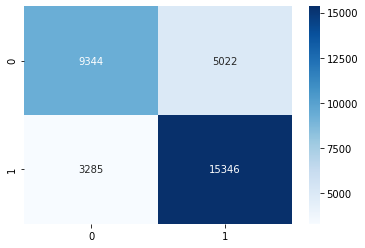

In [53]:
model_log = LogisticRegression(C= clf_log.best_params_['C'], penalty='l2', random_state=0)
model_log.fit(X_train_tfidf, Y_train)

Y_pred = model_log.predict(X_test_tfidf)

f1_score_log = f1_score(Y_test, Y_pred)
print("The f1 score for logistice regression model is ", f1_score_log)

cm_log = confusion_matrix(Y_test, Y_pred)
print("The confusion matrix on the test dataset for logistic regression:")
#print(cm_log)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')

### Naive Bayes

In [54]:
multiNB = MultinomialNB()
parameters = {'alpha':[10 ** x for x in range(-3, 3)]}
clf_NB = GridSearchCV(multiNB, parameters, cv=10, n_jobs=-1)
clf_NB.fit(X_train_tfidf, Y_train)

print("Best estimator=", clf_NB.best_estimator_)
print("Best score =", clf_NB.best_score_)

Best estimator= MultinomialNB(alpha=1)
Best score = 0.7439543638725317


The f1 score for Naive Bayes model is  0.7844408427876822
The confusion matrix on the test dataset for Naive Bayes:


<AxesSubplot:>

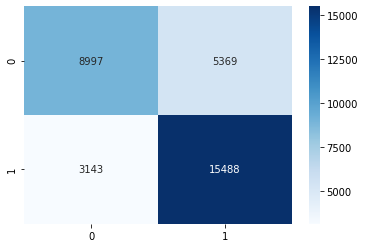

In [55]:
model_NB = MultinomialNB(alpha= clf_NB.best_params_['alpha'])
model_NB.fit(X_train_tfidf, Y_train)

Y_pred = model_NB.predict(X_test_tfidf)

f1_score_NB = f1_score(Y_test, Y_pred)
print("The f1 score for Naive Bayes model is ", f1_score_NB)

cm_NB = confusion_matrix(Y_test, Y_pred)
print("The confusion matrix on the test dataset for Naive Bayes:")
#print(cm_NB)
sns.heatmap(cm_NB, annot=True, fmt='d', cmap='Blues')

### Random Forest

In [56]:
model_RF = RandomForestClassifier()
parameters={'min_samples_split':[10,12,14], 'n_estimators':[100, 200, 350]}
clf_RF = GridSearchCV(model_RF, parameters, cv=10, n_jobs=-1)
clf_RF.fit(X_train_tfidf, Y_train)

print("Best estimator=", clf_RF.best_estimator_)
print("Best score=", clf_RF.best_score_)

Best estimator= RandomForestClassifier(min_samples_split=10, n_estimators=350)
Best score= 0.7357594272257164


The f1 score for Random Forest model is  0.7770627919045148
The confusion matrix on the test dataset for Random Forest:


<AxesSubplot:>

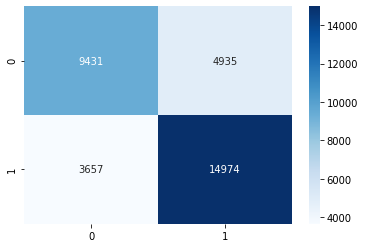

In [57]:
model_RF = RandomForestClassifier(min_samples_split= clf_RF.best_params_['min_samples_split'], n_estimators= clf_RF.best_params_['n_estimators'])
model_RF.fit(X_train_tfidf, Y_train)

Y_pred = model_RF.predict(X_test_tfidf)

f1_score_RF = f1_score(Y_test, Y_pred)
print("The f1 score for Random Forest model is ", f1_score_RF)

cm_RF = confusion_matrix(Y_test, Y_pred)
print("The confusion matrix on the test dataset for Random Forest:")
#print(cm_RF)
sns.heatmap(cm_RF, annot=True, fmt='d', cmap='Blues')

### Gradient Boosting Decision Trees

In [58]:
model_GBDT = GradientBoostingClassifier()
parameters = {'learning_rate':[0.1, 0.3, 0.4], 'n_estimators':[200, 300, 500]}
clf_GBDT = GridSearchCV(model_GBDT, parameters, cv=10, n_jobs=-1)
clf_GBDT.fit(X_train_tfidf, Y_train)

print("Best estimator=", clf_GBDT.best_estimator_)
print("Best score=", clf_GBDT.best_score_)

Best estimator= GradientBoostingClassifier(learning_rate=0.3, n_estimators=500)
Best score= 0.7374164555636507


The f1 score for Gradient Boosting Decision Tree model is  0.7870674537505866
The confusion matrix on the test dataset for Gradient Boosting Decision Tree:


<AxesSubplot:>

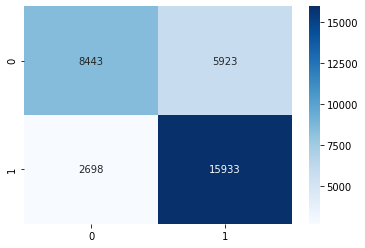

In [59]:
model_GBDT = GradientBoostingClassifier(learning_rate= clf_GBDT.best_params_['learning_rate'], n_estimators= clf_GBDT.best_params_['n_estimators'])
model_GBDT.fit(X_train_tfidf, Y_train)

Y_pred = model_GBDT.predict(X_test_tfidf)

f1_score_GBDT = f1_score(Y_test, Y_pred)
print("The f1 score for Gradient Boosting Decision Tree model is ", f1_score_GBDT)

cm_GBDT = confusion_matrix(Y_test, Y_pred)
print("The confusion matrix on the test dataset for Gradient Boosting Decision Tree:")
#print(cm_GBDT)
sns.heatmap(cm_GBDT, annot=True, fmt='d', cmap='Blues')

### Linear SVC

In [60]:
model_SVC = LinearSVC()
parameters = {"C":[0.001, 0.01, 0.1, 1, 10]}
clf_SVC = GridSearchCV(model_SVC, parameters, cv=10, n_jobs=-1)
clf_SVC.fit(X_train_tfidf, Y_train)

print("Best estimator= ", clf_SVC.best_estimator_)
print("Best score= ", clf_SVC.best_score_)

Best estimator=  LinearSVC(C=0.1)
Best score=  0.7502835709495514


The f1 score for Gradient linear SVC model is  0.7886519032554343
The confusion matrix on the test dataset for linear SVC:


<AxesSubplot:>

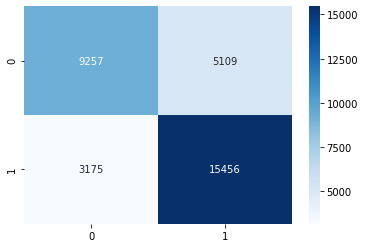

In [61]:
model_SVC = LinearSVC(C=clf_SVC.best_params_["C"])
model_SVC.fit(X_train_tfidf,Y_train)

Y_pred = model_SVC.predict(X_test_tfidf)

f1_score_SVC = f1_score(Y_test, Y_pred)
print("The f1 score for Gradient linear SVC model is ", f1_score_SVC)

cm_SVC = confusion_matrix(Y_test, Y_pred)
print("The confusion matrix on the test dataset for linear SVC:")
#print(cm_SVC)
sns.heatmap(cm_SVC, annot=True, fmt='d', cmap='Blues')

## Deep Learning Models

### Data preprocessing

In [109]:
#Y = train[['Sentiment']]
#X = train[['clean_SentimentText']]
X = train[['preprocessed_SentimentText']]

In [110]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.20, stratify=Y)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train,Y_train, test_size=0.20, stratify=Y_train)

In [111]:
print(X_train.shape, Y_train.shape)
print(X_cv.shape, Y_cv.shape)
print(X_test.shape, Y_test.shape)

(63992, 1) (63992, 1)
(15999, 1) (15999, 1)
(19998, 1) (19998, 1)


In [113]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(X_train['preprocessed_SentimentText'])

X_train_seq = tokenizer.texts_to_sequences(X_train['preprocessed_SentimentText'])
X_cv_seq = tokenizer.texts_to_sequences(X_cv['preprocessed_SentimentText'])
X_test_seq = tokenizer.texts_to_sequences(X_test['preprocessed_SentimentText'])

word_index = tokenizer.word_index
result     = [len(x.split()) for x in X_train['preprocessed_SentimentText']]

print("Text informations:")
print("Max length:   {}".format(np.max(result)))
print("Min length:   {}".format(np.min(result)))
print("Mean length:  {}".format(np.mean(result)))

Text informations:
Max length:   84
Min length:   0
Mean length:  9.180772596574572


In [114]:
max_length= int(np.max(result))
print(max_length)

84


In [115]:
Q3_len = int(X_train['preprocessed_SentimentText'].str.split().apply(len).describe()['75%'])
X_train['preprocessed_SentimentText'].str.split().apply(len).describe()

count    63992.000000
mean         9.180773
std          5.233915
min          0.000000
25%          5.000000
50%          8.000000
75%         13.000000
max         84.000000
Name: preprocessed_SentimentText, dtype: float64

In [116]:
X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_length)
X_cv_pad = tf.keras.preprocessing.sequence.pad_sequences(X_cv_seq, maxlen=max_length)
X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_length)

In [117]:
print(X_train_pad.shape)
print(X_cv_pad.shape)
print(X_test_pad.shape)

(63992, 84)
(15999, 84)
(19998, 84)


In [120]:
%%time

#Reference from https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
glove_file = r'D:\Twitter Sentiment Analysis\Dataset/glove.840B.300d.pkl'
glove = np.load(glove_file, allow_pickle=True)

EMBEDDING_DIM=300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(36910, 300)
Wall time: 7.76 s


In [121]:
def Recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1_score(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Sequential model using RNN with pre-trained word embeddings

In [122]:
tf.random.set_seed(0)
np.random.seed(0)

In [124]:
tf.compat.v1.keras.backend.get_session()

In [125]:
def build_rnn():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=max_length))
    model.add(tf.keras.layers.Embedding(len(tokenizer.word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length, trainable=True))
    #model.add(tf.keras.layers.SimpleRNN(32, return_sequences=True, recurrent_dropout=0.5, bias_regularizer='L2'))
    model.add(tf.keras.layers.SimpleRNN(512, return_sequences=True, recurrent_dropout=0.3))
    model.add(tf.keras.layers.SimpleRNN(512, recurrent_dropout=0.3))
    model.add(tf.keras.layers.Dense(len(Y_train.columns), activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', F1_score, Precision, Recall])
    return model

In [126]:
model_rnn = build_rnn()
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 84, 300)           11073000  
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 84, 512)           416256    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 512)               524800    
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 12,014,569
Trainable params: 12,014,569
Non-trainable params: 0
_________________________________________________________________


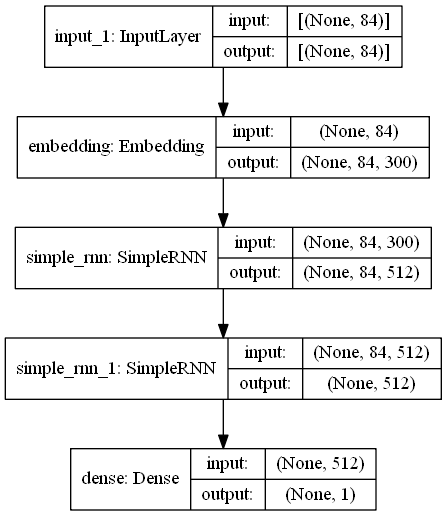

In [127]:
tf.keras.utils.plot_model(model_rnn,to_file='modelRNN.png', show_shapes=True, show_layer_names=True)

In [128]:
checkpoint_path = "D:\Twitter Sentiment Analysis"
checkpoint_dir = os.path.dirname(checkpoint_path)
file_path=os.path.join(checkpoint_dir, "Twitter Sentiment Analysis", "checkpoint", "weights-{epoch:02d}-{val_F1_score:.4f}")

earlystop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, save_weights_only=True, monitor='val_F1_score', mode='max', save_best_only=True)

log_dir = os.path.join(checkpoint_dir, "Twitter Sentiment Analysis", "logs",'fit', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)

In [129]:
%%time
rnn_hist = model_rnn.fit(X_train_pad, Y_train, epochs=10, validation_data=(X_cv_pad, Y_cv), batch_size=64, 
                         callbacks=[earlystop, model_checkpoint_callback, tensorboard_callback])

Epoch 1/10
1000/1000 [==============================] - 729s 728ms/step - loss: 0.5686 - accuracy: 0.7041 - F1_score: 0.7247 - Precision: 1.0000 - Recall: 0.5849 - val_loss: 0.5175 - val_accuracy: 0.7544 - val_F1_score: 0.7610 - val_Precision: 1.0000 - val_Recall: 0.6162
Epoch 2/10
1000/1000 [==============================] - 798s 798ms/step - loss: 0.5032 - accuracy: 0.7510 - F1_score: 0.7283 - Precision: 0.9990 - Recall: 0.5893 - val_loss: 0.5339 - val_accuracy: 0.7455 - val_F1_score: 0.7086 - val_Precision: 1.0000 - val_Recall: 0.5505
Epoch 3/10
1000/1000 [==============================] - 807s 807ms/step - loss: 0.5137 - accuracy: 0.7519 - F1_score: 0.7338 - Precision: 0.9970 - Recall: 0.5961 - val_loss: 0.6212 - val_accuracy: 0.7055 - val_F1_score: 0.5328 - val_Precision: 1.0000 - val_Recall: 0.3653
Epoch 00003: early stopping
Wall time: 38min 55s


In [130]:
for metric, values in rnn_hist.history.items():
    print(metric, ":", values)

loss : [0.5685679912567139, 0.5031551718711853, 0.5136750936508179]
accuracy : [0.7040567398071289, 0.750968873500824, 0.7518908381462097]
F1_score : [0.7246702313423157, 0.7283213138580322, 0.7338063716888428]
Precision : [1.0, 0.9990000128746033, 0.996999979019165]
Recall : [0.5849397778511047, 0.5893124938011169, 0.5961004495620728]
val_loss : [0.5175146460533142, 0.5338994860649109, 0.6211705803871155]
val_accuracy : [0.754422128200531, 0.7455465793609619, 0.7054815888404846]
val_F1_score : [0.7609983682632446, 0.7085798382759094, 0.5328055620193481]
val_Precision : [1.0, 1.0, 1.0]
val_Recall : [0.6161696314811707, 0.5505436658859253, 0.36533334851264954]


In [131]:
loss_rnn, accuracy_rnn, f1_score_rnn, precision_rnn, recall_rnn = model_rnn.evaluate(X_test_pad, Y_test, verbose=0)
print('F1 score for RNN model: %f' % f1_score_rnn)

F1 score for RNN model: 0.513728


In [132]:
%load_ext  tensorboard

In [133]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [134]:
%tensorboard --logdir="D:\Twitter Sentiment Analysis\logs\fit"

### Stacked LSTMs with pre-trained word embeddings

In [135]:
def build_LSTM():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=max_length, ))
    model.add(tf.keras.layers.Embedding(len(tokenizer.word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length, trainable=True))
    model.add(tf.keras.layers.LSTM(512, return_sequences=True, recurrent_dropout=0.3))
    model.add(tf.keras.layers.LSTM(512, recurrent_dropout=0.3))
    model.add(tf.keras.layers.Dense(len(Y_train.columns), activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', F1_score, Precision, Recall])
    
    return model

In [136]:
model_LSTM = build_LSTM()
model_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 84, 300)           11073000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 84, 512)           1665024   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,837,737
Trainable params: 14,837,737
Non-trainable params: 0
_________________________________________________________________


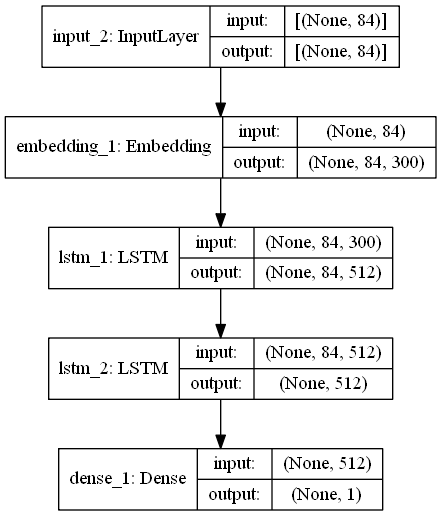

In [137]:
tf.keras.utils.plot_model(model_LSTM,to_file='model_LSTM.png', show_shapes=True, show_layer_names=True)

In [139]:
LSTM_hist = model_LSTM.fit(X_train_pad, Y_train, epochs=10, validation_data=(X_cv_pad, Y_cv), batch_size=64, 
                           callbacks=[earlystop, model_checkpoint_callback, tensorboard_callback])

Epoch 1/10
1000/1000 [==============================] - 5990s 6s/step - loss: 0.4920 - accuracy: 0.7573 - F1_score: 0.7286 - Precision: 1.0000 - Recall: 0.5786 - val_loss: 0.4658 - val_accuracy: 0.7768 - val_F1_score: 0.7355 - val_Precision: 1.0000 - val_Recall: 0.5838
Epoch 2/10
1000/1000 [==============================] - 5448s 5s/step - loss: 0.4015 - accuracy: 0.8142 - F1_score: 0.7232 - Precision: 1.0000 - Recall: 0.5703 - val_loss: 0.4880 - val_accuracy: 0.7695 - val_F1_score: 0.7103 - val_Precision: 1.0000 - val_Recall: 0.5532
Epoch 3/10
1000/1000 [==============================] - 28814s 29s/step - loss: 0.2892 - accuracy: 0.8715 - F1_score: 0.7241 - Precision: 1.0000 - Recall: 0.5703 - val_loss: 0.5642 - val_accuracy: 0.7554 - val_F1_score: 0.7288 - val_Precision: 1.0000 - val_Recall: 0.5754
Epoch 00003: early stopping


In [140]:
loss_lstm, accuracy_lstm, f1_score_lstm, precision_lstm, recall_lstm = model_LSTM.evaluate(X_test_pad, Y_test, verbose=0)
print('F1 score for LSTM model: %f' % f1_score_lstm) 

F1 score for LSTM model: 0.720554


In [141]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [142]:
%tensorboard --logdir="D:\Twitter Sentiment Analysis\logs\fits"

### Stacked GRUs with pre-trained word embeddings

In [143]:
def build_GRU():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=max_length, ))
    model.add(tf.keras.layers.Embedding(len(tokenizer.word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length, trainable=True))
    model.add(tf.keras.layers.GRU(512, return_sequences=True, recurrent_dropout=0.3))
    model.add(tf.keras.layers.GRU(512, recurrent_dropout=0.3))
    model.add(tf.keras.layers.Dense(len(Y_train.columns), activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', F1_score, Precision, Recall])
    
    return model

In [144]:
model_GRU = build_GRU()
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 84, 300)           11073000  
_________________________________________________________________
gru (GRU)                    (None, 84, 512)           1250304   
_________________________________________________________________
gru_1 (GRU)                  (None, 512)               1575936   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 13,899,753
Trainable params: 13,899,753
Non-trainable params: 0
_________________________________________________________________


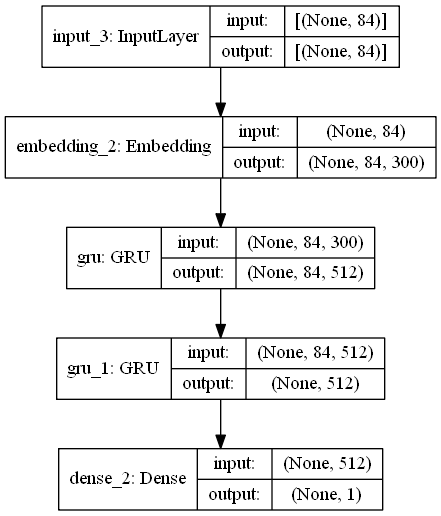

In [147]:
 tf.keras.utils.plot_model(model_GRU,to_file='model_GRU.png', show_shapes=True, show_layer_names=True)

In [149]:
GRU_hist = model_GRU.fit(X_train_pad, Y_train, epochs=5, validation_data=(X_cv_pad, Y_cv), batch_size=64, 
                         callbacks=[earlystop, model_checkpoint_callback, tensorboard_callback])

Epoch 1/5
1000/1000 [==============================] - 6655s 7s/step - loss: 0.4923 - accuracy: 0.7576 - F1_score: 0.7303 - Precision: 0.9990 - Recall: 0.5806 - val_loss: 0.4672 - val_accuracy: 0.7739 - val_F1_score: 0.7527 - val_Precision: 1.0000 - val_Recall: 0.6056
Epoch 2/5
1000/1000 [==============================] - 6626s 7s/step - loss: 0.3939 - accuracy: 0.8186 - F1_score: 0.7223 - Precision: 1.0000 - Recall: 0.5687 - val_loss: 0.4868 - val_accuracy: 0.7701 - val_F1_score: 0.7400 - val_Precision: 1.0000 - val_Recall: 0.5896
Epoch 3/5
1000/1000 [==============================] - 7357s 7s/step - loss: 0.2787 - accuracy: 0.8776 - F1_score: 0.7238 - Precision: 1.0000 - Recall: 0.5700 - val_loss: 0.5802 - val_accuracy: 0.7506 - val_F1_score: 0.7338 - val_Precision: 1.0000 - val_Recall: 0.5815
Epoch 00003: early stopping


In [150]:
loss_GRU, accuracy_GRU, f1_score_GRU, precision_GRU, recall_GRU = model_GRU.evaluate(X_test_pad, Y_test, verbose=0)
print('F1 score for GRU model: %f' % f1_score_GRU) 

F1 score for GRU model: 0.725504


### Bidirectional RNN

In [156]:
def build_biRNN():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=max_length, ))
    model.add(tf.keras.layers.Embedding(len(tokenizer.word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length, trainable=True))
    #model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(512, return_sequences=True, recurrent_dropout=0.3)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(512, recurrent_dropout=0.3)))
    model.add(tf.keras.layers.Dense(len(Y_train.columns), activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', F1_score, Precision, Recall])
    
    return model

In [157]:
model_biRNN = build_biRNN()
model_biRNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 84, 300)           11073000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              832512    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
Total params: 11,906,537
Trainable params: 11,906,537
Non-trainable params: 0
_________________________________________________________________


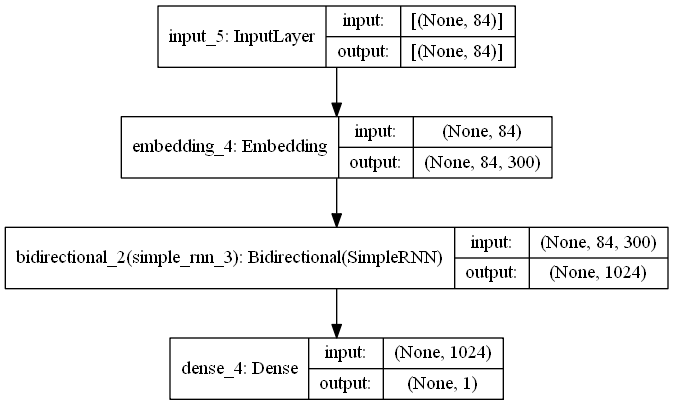

In [158]:
tf.keras.utils.plot_model(model_biRNN,to_file='model_biRNN.png', show_shapes=True, show_layer_names=True)

In [160]:
biRNN_hist = model_biRNN.fit(X_train_pad, Y_train, epochs=10, validation_data=(X_cv_pad, Y_cv), batch_size=64, 
                               callbacks=[earlystop, model_checkpoint_callback, tensorboard_callback])

Epoch 1/10
1000/1000 [==============================] - 1982s 2s/step - loss: 0.6101 - accuracy: 0.6713 - F1_score: 0.7356 - Precision: 1.0000 - Recall: 0.6037 - val_loss: 0.6180 - val_accuracy: 0.6779 - val_F1_score: 0.4708 - val_Precision: 1.0000 - val_Recall: 0.3103
Epoch 2/10
1000/1000 [==============================] - 2032s 2s/step - loss: 0.5187 - accuracy: 0.7426 - F1_score: 0.7306 - Precision: 1.0000 - Recall: 0.5876 - val_loss: 0.5140 - val_accuracy: 0.7514 - val_F1_score: 0.7595 - val_Precision: 1.0000 - val_Recall: 0.6144
Epoch 3/10
1000/1000 [==============================] - 1998s 2s/step - loss: 0.5042 - accuracy: 0.7562 - F1_score: 0.7280 - Precision: 1.0000 - Recall: 0.5830 - val_loss: 0.5479 - val_accuracy: 0.7381 - val_F1_score: 0.7348 - val_Precision: 1.0000 - val_Recall: 0.5830
Epoch 4/10
1000/1000 [==============================] - 1651s 2s/step - loss: 0.4291 - accuracy: 0.8052 - F1_score: 0.7226 - Precision: 1.0000 - Recall: 0.5707 - val_loss: 0.5413 - val_accur

In [161]:
loss_biRNN, accuracy_biRNN, f1_score_biRNN, precision_biRNN, recall_biRNN = model_biRNN.evaluate(X_test_pad, Y_test, verbose=0)
print('F1 score for bidirectional RNN model: %f' % f1_score_biRNN) 

F1 score for bidirectional RNN model: 0.699530


In [151]:
def build_biLSTM():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=max_length, ))
    model.add(tf.keras.layers.Embedding(len(tokenizer.word_index)+1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_length, trainable=True))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(512, return_sequences=True, recurrent_dropout=0.3)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, recurrent_dropout=0.3)))
    model.add(tf.keras.layers.Dense(len(Y_train.columns), activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', F1_score, Precision, Recall])
    
    return model

In [152]:
model_biLSTM = build_biLSTM()
model_biLSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 84, 300)           11073000  
_________________________________________________________________
bidirectional (Bidirectional (None, 84, 1024)          832512    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 18,202,089
Trainable params: 18,202,089
Non-trainable params: 0
_________________________________________________________________


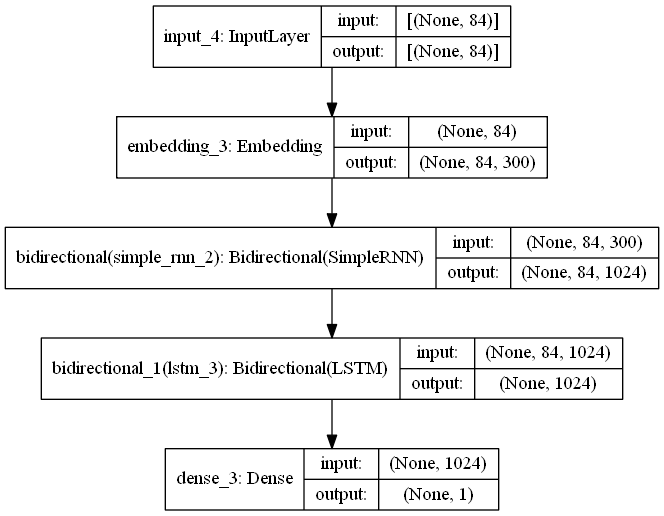

In [153]:
tf.keras.utils.plot_model(model_biLSTM,to_file='model_biLSTM.png', show_shapes=True, show_layer_names=True)

In [154]:
biRLSTM_hist = model_biLSTM.fit(X_train_pad, Y_train, epochs=10, validation_data=(X_cv_pad, Y_cv), batch_size=64, 
                               callbacks=[earlystop, model_checkpoint_callback, tensorboard_callback])

Epoch 1/10
1000/1000 [==============================] - 15409s 15s/step - loss: 0.5437 - accuracy: 0.7210 - F1_score: 0.7272 - Precision: 0.9990 - Recall: 0.5834 - val_loss: 0.5169 - val_accuracy: 0.7514 - val_F1_score: 0.6405 - val_Precision: 1.0000 - val_Recall: 0.4735
Epoch 2/10
1000/1000 [==============================] - 45553s 46s/step - loss: 0.4479 - accuracy: 0.7886 - F1_score: 0.7184 - Precision: 1.0000 - Recall: 0.5656 - val_loss: 0.4987 - val_accuracy: 0.7663 - val_F1_score: 0.7372 - val_Precision: 1.0000 - val_Recall: 0.5859
Epoch 3/10
1000/1000 [==============================] - 16117s 16s/step - loss: 0.3895 - accuracy: 0.8217 - F1_score: 0.7173 - Precision: 1.0000 - Recall: 0.5630 - val_loss: 0.5203 - val_accuracy: 0.7574 - val_F1_score: 0.7510 - val_Precision: 1.0000 - val_Recall: 0.6035
Epoch 4/10
1000/1000 [==============================] - 15619s 16s/step - loss: 0.3406 - accuracy: 0.8473 - F1_score: 0.7184 - Precision: 1.0000 - Recall: 0.5640 - val_loss: 0.5644 - v

In [155]:
loss_biLSTM, accuracy_biLSTM, f1_score_biLSTM, precision_biLSTM, recall_biLSTM = model_biLSTM.evaluate(X_test_pad, Y_test, verbose=0)
print('F1 score for bidirectional LSTM model: %f' % f1_score_biLSTM) 

F1 score for bidirectional LSTM model: 0.696684


### BERT

In [67]:
bert_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3", trainable=True)

In [68]:
"""bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")"""

'bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")\nbert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")'

In [94]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocessor(text_input)
outputs = bert_encoder(preprocessed_text)
pooled_output = outputs["pooled_output"]      # [batch_size, 768].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

# Neural network layers
#l = tf.keras.layers.Dropout(0.3, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dropout(0.3, name="dropout")(pooled_output)
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model_BERT = tf.keras.Model(inputs=[text_input], outputs = [l])

In [95]:
model_BERT.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'encoder_outputs':  109482241   keras_layer[2][0]                
                                                                 keras_layer[2][1]                
                                                                 keras_layer[2][2]                
____________________________________________________________________________________________

In [96]:
model_BERT.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', F1_score, Precision, Recall])

In [100]:
BERT_hist = model_BERT.fit(X_train, Y_train, epochs=5, validation_data=(X_cv, Y_cv), batch_size=64
          , callbacks=[earlystop, model_checkpoint_callback, tensorboard_callback])

Epoch 1/5
1000/1000 [==============================] - 49372s 49s/step - loss: 0.7161 - accuracy: 0.5361 - F1_score: 0.8445 - Precision: 0.9950 - Recall: 0.7800 - val_loss: 0.6851 - val_accuracy: 0.5646 - val_F1_score: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000
Epoch 2/5
1000/1000 [==============================] - 69878s 70s/step - loss: 0.6889 - accuracy: 0.5538 - F1_score: 0.9471 - Precision: 1.0000 - Recall: 0.9217 - val_loss: 0.6849 - val_accuracy: 0.5646 - val_F1_score: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000
Epoch 3/5
1000/1000 [==============================] - 64981s 65s/step - loss: 0.6868 - accuracy: 0.5613 - F1_score: 0.9832 - Precision: 0.9990 - Recall: 0.9750 - val_loss: 0.6849 - val_accuracy: 0.5646 - val_F1_score: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000
Epoch 4/5
1000/1000 [==============================] - 66188s 66s/step - loss: 0.6860 - accuracy: 0.5645 - F1_score: 0.9996 - Precision: 1.0000 - Recall: 0.9992 - val_loss: 0.6852 - val_a

In [102]:
loss_BERT, accuracy_BERT, f1_score_BERT, precision_BERT, recall_BERT = model_BERT.evaluate(X_test, Y_test, verbose=0)
print('F1 score for BERT model: %f' % f1_score_BERT) 

F1 score for BERT model: 1.000000


### Summary

In [166]:
# assigning data
table_data = [("Logistic Regression", f1_score_log, "accuracy_lg")
              ,("Naive Bayes", f1_score_NB, "accuracy_NB")
              ,("Random Forest", f1_score_RF, "accuracy_RF")
              ,("Gradient Boosting Decision Trees", f1_score_GBDT, "accuracy_GBDT")
              ,("Linear SVC", f1_score_SVC, "accuracy_SVC")              
              ,("RNN", f1_score_rnn, accuracy_rnn)
              ,("LSTM", f1_score_lstm, accuracy_lstm)
              ,("GRU", f1_score_GRU, accuracy_GRU)
              ,("Bidirectional RNN", f1_score_biRNN, accuracy_biRNN)              
              ,("Bidirectional LSTM", f1_score_biLSTM, accuracy_biLSTM)              
              ,("BERT", f1_score_BERT, accuracy_BERT, accuracy_BERT)              
             ]

# creating header
table_head = ["Model", "F1 Score", "Accuracy"]

# displaying the table
print(tabulate(table_data, headers=table_head, tablefmt="grid"))

+----------------------------------+------------+--------------------+
| Model                            |   F1 Score | Accuracy           |
+==================================+============+====================+
| Logistic Regression              |   0.786995 | accuracy_lg        |
+----------------------------------+------------+--------------------+
| Naive Bayes                      |   0.784441 | accuracy_NB        |
+----------------------------------+------------+--------------------+
| Random Forest                    |   0.777063 | accuracy_RF        |
+----------------------------------+------------+--------------------+
| Gradient Boosting Decision Trees |   0.787067 | accuracy_GBDT      |
+----------------------------------+------------+--------------------+
| Linear SVC                       |   0.788652 | accuracy_SVC       |
+----------------------------------+------------+--------------------+
| RNN                              |   0.513728 | 0.702170193195343  |
+-----

Conclusion:
    As we can see from the above table, the f1 score of BERT is the highest but it does not have the highest accuracy.